In [1]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.makedirs('/content/drive/MyDrive/sentiment_project', exist_ok=True)

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

In [5]:
df = pd.read_csv('/content/drive/MyDrive/sentiment_project/processed_reviews_100k.csv')

In [ ]:
df.info()
df.describe()
df.shape
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49962 entries, 0 to 49961
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             49962 non-null  float64
 1   title              49962 non-null  object 
 2   text               49962 non-null  object 
 3   timestamp          49962 non-null  int64  
 4   helpful_vote       49962 non-null  int64  
 5   verified_purchase  49962 non-null  int64  
 6   label              49962 non-null  object 
 7   full_text          49962 non-null  object 
 8   sentiment          49962 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [6]:
print(df[['full_text', 'sentiment']].isna().sum())

full_text    0
sentiment    0
dtype: int64


In [ ]:
df.head()

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [7]:
X_text = df['full_text']
X_extra = df[['verified_purchase', 'helpful_vote']]
y = df['sentiment']

In [10]:
y.value_counts()

,count
sentiment,
positive,63932
negative,23635
neutral,12433


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

***Vectorization TF-IDF Selection par chi*** **2**

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test) # une transformation en se basant sur le vocabulaire appris du train not the new words in the test set

In [ ]:
# selection des 'features' avec chi 2
from sklearn.feature_selection import SelectKBest, chi2

# le fit : sélectionner les 300 features avec les scores chi² les plus élevés
# le transform :  supprimer toutes les cfeatures qui ne font pas partie des 300 retenues
selector = SelectKBest(score_func=chi2, k=300)
X_train_selected = selector.fit_transform(X_train_vec, y_train)

X_test_selected = selector.transform(X_test_vec)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: LinearSVC with Class Weight Balancing")

target_names = ['negative', 'neutral', 'positive']


svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

start_time = time.time()
svm_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time

print(f"Training took {train_time/60:.2f} minutes")

y_pred_svm = svm_model.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=target_names)}")

# Cross-validation (5 folds)
cv_scores = cross_val_score(svm_model, X_train_selected, y_train, cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Model: LinearSVC with Class Weight Balancing
Training took 0.01 minutes
Accuracy: 0.8219
F1 Score (macro): 0.7231
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.77      0.76      2321
     neutral       0.63      0.44      0.52      1244
    positive       0.88      0.91      0.89      6428

    accuracy                           0.82      9993
   macro avg       0.75      0.71      0.72      9993
weighted avg       0.81      0.82      0.82      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.7213 (+/- 0.0069)


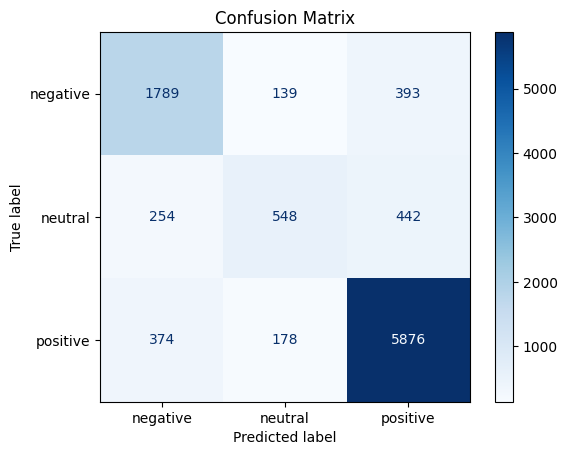

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
joblib.dump(svm_model, '/content/drive/MyDrive/sentiment_project/svm_model_bert_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_bert_chi2.joblib']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: Logistic Regression with Class Weight Balancing")

# Define class labels (ensure same order as LabelEncoder)
target_names = ['negative', 'neutral', 'positive']

# Create model with solver optimized for large datasets
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='saga',          # Good for large data + supports L1/L2 penalties
    n_jobs=-1               # Use all cores during fitting
)

# Train model and track training time
start_time = time.time()
lr_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time / 60:.2f} minutes")

# Predict
y_pred_lr = lr_model.predict(X_test_selected)

# Evaluation
acc = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr, target_names=target_names)}")

# Cross-validation (parallelized)
cv_scores = cross_val_score(
    lr_model,
    X_train_selected,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Logistic Regression with Class Weight Balancing
Training took 0.01 minutes
Accuracy: 0.7644
F1 Score (macro): 0.6921
Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.84      0.74      2321
     neutral       0.42      0.60      0.49      1244
    positive       0.94      0.77      0.85      6428

    accuracy                           0.76      9993
   macro avg       0.67      0.73      0.69      9993
weighted avg       0.81      0.76      0.78      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6908 (+/- 0.0045)


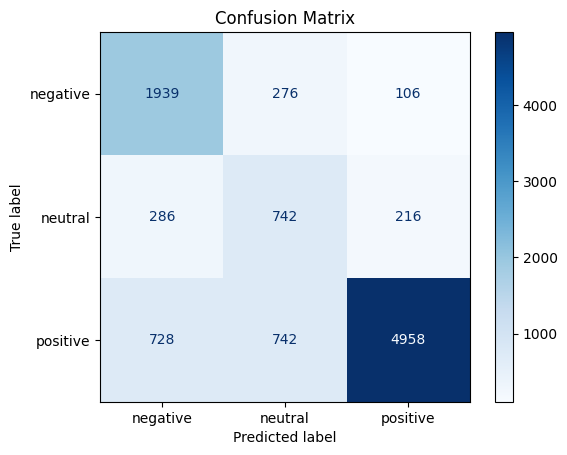

In [ ]:
cm2 = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(lr_model, '/content/drive/MyDrive/sentiment_project/lr_model_bert_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/lr_model_bert_chi2.joblib']

In [ ]:
print("Model: Multinomial Naive Bayes (on chi²-selected TF-IDF features)")

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

target_names = ['negative', 'neutral', 'positive']

mnb_model = MultinomialNB()


start_time = time.time()
mnb_model.fit(X_train_selected, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time:.2f} seconds")

y_pred_mnb = mnb_model.predict(X_test_selected)

acc = accuracy_score(y_test, y_pred_mnb)
f1 = f1_score(y_test, y_pred_mnb, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_mnb, target_names=target_names)}")


cv_scores = cross_val_score(
    mnb_model,
    X_train_selected,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Multinomial Naive Bayes (on chi²-selected TF-IDF features)
Training took 0.09 seconds
Accuracy: 0.7904
F1 Score (macro): 0.6308
Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.56      0.69      2321
     neutral       0.82      0.21      0.34      1244
    positive       0.77      0.98      0.87      6428

    accuracy                           0.79      9993
   macro avg       0.82      0.59      0.63      9993
weighted avg       0.80      0.79      0.76      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6340 (+/- 0.0035)


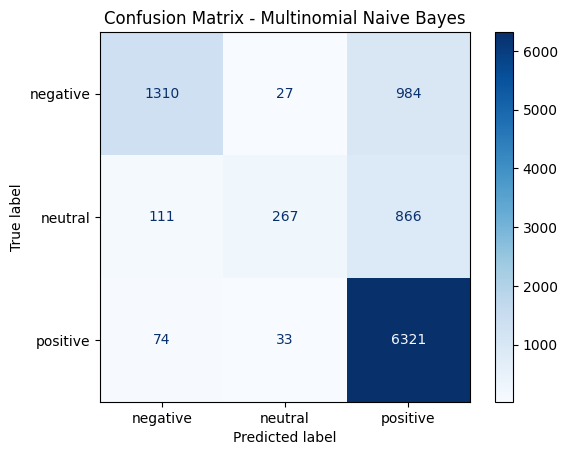

In [ ]:
cm_mnb = confusion_matrix(y_test, y_pred_mnb)

# Display the confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

In [ ]:
joblib.dump(mnb_model, '/content/drive/MyDrive/sentiment_project/mnb_model_bert_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/mnb_model_bert_chi2.joblib']

**Vectorization TF-IDF Selection par ACP**

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.transform(X_test_vec)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

print("Model: LinearSVC with Class Weight Balancing")

target_names = ['negative', 'neutral', 'positive']

svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

start_time = time.time()
svm_model.fit(X_train_reduced, y_train)
train_time = time.time() - start_time

print(f"Training took {train_time/60:.2f} minutes")

y_pred_svm = svm_model.predict(X_test_reduced)

acc = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=target_names)}")

# Cross-validation (5 folds)
cv_scores = cross_val_score(svm_model, X_train_reduced, y_train, cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: LinearSVC with Class Weight Balancing
Training took 0.09 minutes
Accuracy: 0.8026
F1 Score (macro): 0.7015
Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.83      0.73      2321
     neutral       0.66      0.39      0.49      1244
    positive       0.89      0.87      0.88      6428

    accuracy                           0.80      9993
   macro avg       0.73      0.70      0.70      9993
weighted avg       0.81      0.80      0.80      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6895 (+/- 0.0038)


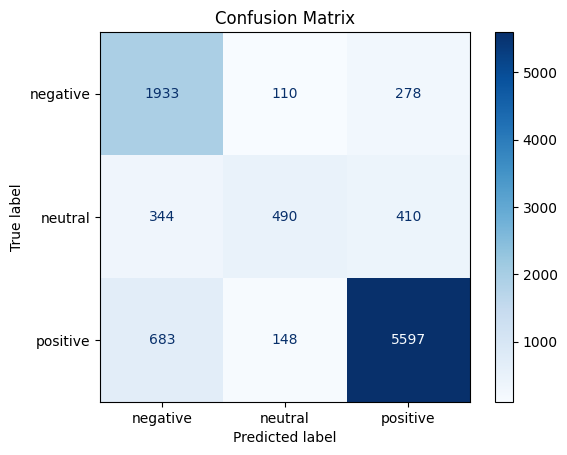

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(svm_model, '/content/drive/MyDrive/sentiment_project/svm_model_bert_acp.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_bert_acp.joblib']

In [ ]:
print("Model: Logistic Regression with Class Weight Balancing (on SVD-reduced TF-IDF)")

# Define class labels (make sure this matches your label encoding)
target_names = ['negative', 'neutral', 'positive']

# Create the model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='saga',     # good for large sparse data & supports regularization
    n_jobs=-1          # utilize all CPUs
)

# Train and time it
start_time = time.time()
lr_model.fit(X_train_reduced, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time / 60:.2f} minutes")

# Predict
y_pred_lr = lr_model.predict(X_test_reduced)

# Evaluate
acc = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr, target_names=target_names)}")

# Cross-validation
cv_scores = cross_val_score(
    lr_model,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Logistic Regression with Class Weight Balancing (on SVD-reduced TF-IDF)
Training took 0.08 minutes
Accuracy: 0.7526
F1 Score (macro): 0.6807
Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.81      0.72      2321
     neutral       0.40      0.60      0.48      1244
    positive       0.93      0.76      0.84      6428

    accuracy                           0.75      9993
   macro avg       0.66      0.72      0.68      9993
weighted avg       0.80      0.75      0.77      9993

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6716 (+/- 0.0042)


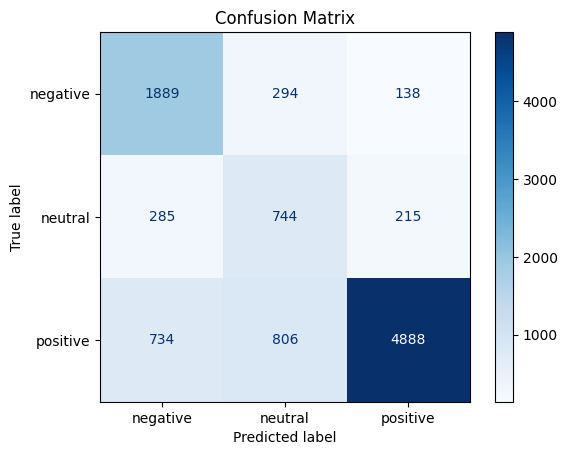

In [ ]:
cm2 = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(svm_model, '/content/drive/MyDrive/sentiment_project/lr_model_bert_acp.joblib')

['/content/drive/MyDrive/sentiment_project/lr_model_bert_acp.joblib']

In [ ]:
print("Model: Multinomial Naive Bayes (on SVD-reduced TF-IDF)")

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time

target_names = ['negative', 'neutral', 'positive']

mnb_model_svd = MultinomialNB()

start_time = time.time()
mnb_model_svd.fit(X_train_reduced, y_train)
train_time = time.time() - start_time
print(f"Training took {train_time:.2f} seconds")

y_pred_mnb_svd = mnb_model_svd.predict(X_test_reduced)

acc = accuracy_score(y_test, y_pred_mnb_svd)
f1 = f1_score(y_test, y_pred_mnb_svd, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_mnb_svd, target_names=target_names)}")

cv_scores = cross_val_score(
    mnb_model_svd,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(5),
    scoring='f1_macro',
    n_jobs=-1
)
print("Cross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Model: Multinomial Naive Bayes (on SVD-reduced TF-IDF)


ValueError: Negative values in data passed to MultinomialNB (input X).

***Pipelines***

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('chi2', SelectKBest(score_func=chi2)),
    ('clf', LinearSVC())
])

pipeline_chi2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('chi2', SelectKBest(score_func=chi2, k=300)),
    ('clf', LinearSVC())
])

pipeline_svd = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', LinearSVC())
])

In [14]:
param_grid = [
    {
        'tfidf__max_features': [4000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'chi2__k': [200, 3000],
        'clf': [LinearSVC(max_iter=3000)],
        'clf__C': [1, 10]
    },
    {
        'tfidf__max_features': [4000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'chi2__k': [200, 3000],
        'clf': [LogisticRegression(max_iter=3000)],
        'clf__C': [1, 10]
    },
    {
        'tfidf__max_features': [4000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'chi2__k': [200, 3000],
        'clf': [MultinomialNB()]
        # No 'clf__C' here because MultinomialNB does not have C
    }
]

f1_scorer = make_scorer(f1_score, average='macro')
start_time = time.time()
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"\nGridSearch training took {train_time:.2f} seconds")

y_pred = grid.predict(X_test)

print("\nBest parameters:")
for param_name in grid.best_params_:
    print(f"{param_name}: {grid.best_params_[param_name]}")
print(f"Best CV F1 Score (macro): {grid.best_score_:.4f}")

# Evaluation on test set
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# CV on best model (optional but useful)
cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1)
print("\nCross-validation (5 folds) on training data:")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
# print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
# print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
# print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
# print("Best C (LinearSVC):", grid.best_params_['clf__C'])
# print("Best parameters (F1 score):", grid.best_score_)
# print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(



GridSearch training took 1014.59 seconds

Best parameters:
chi2__k: 200
clf: LinearSVC(max_iter=3000)
clf__C: 1
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.8164
F1 Score (macro): 0.6815
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.73      0.76      4727
     neutral       0.76      0.27      0.40      2487
    positive       0.83      0.95      0.89     12786

    accuracy                           0.82     20000
   macro avg       0.79      0.65      0.68     20000
weighted avg       0.81      0.82      0.80     20000

Confusion Matrix:
[[ 3457    78  1192]
 [  500   676  1311]
 [  461   131 12194]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6819 (+/- 0.0027)


In [19]:
import joblib
joblib.dump(grid.best_estimator_, '/content/drive/MyDrive/sentiment_project/svm_model_pipeline_chi2_default.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_pipeline_chi2_default.joblib']

In [41]:
def run_grid_search_and_evaluate(pipeline, param_grid, X_train, y_train, X_test, y_test, target_names=None):
    f1_scorer = make_scorer(f1_score, average='macro', zero_division=0)

    print("Starting GridSearchCV...")
    start_time = time.time()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1)
    grid.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"\nGridSearch training took {train_time:.2f} seconds")

    y_pred = grid.predict(X_test)

    print("\nBest parameters:")
    for param_name, param_value in grid.best_params_.items():
        print(f"{param_name}: {param_value}")

    print(f"Best CV F1 Score (macro): {grid.best_score_:.4f}")

    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
    if target_names:
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=target_names))
    else:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train,
                                cv=StratifiedKFold(5),
                                scoring='f1_macro', n_jobs=-1)
    print("\nCross-validation (5 folds) on training data:")
    print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    return grid


In [24]:
param_grid = [
    {
        'tfidf__max_features': [4000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'chi2__k': [200, 3000],
        'clf': [LinearSVC(max_iter=3000)],
        'clf__C': [1, 10]
    },
    {
        'tfidf__max_features': [4000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'chi2__k': [200, 3000],
        'clf': [LogisticRegression(max_iter=3000)],
        'clf__C': [1, 10]
    },
    {
        'tfidf__max_features': [4000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'chi2__k': [200, 3000],
        'clf': [MultinomialNB()]
        # No 'clf__C' here because MultinomialNB does not have C
    }
]
param_grid_svd = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [100, 300],
    'clf__C': [1, 10]
}

target_names = ['negative', 'neutral', 'positive']

In [21]:
best_model=run_grid_search_and_evaluate(pipeline_chi2, param_grid, X_train, y_train, X_test, y_test, target_names)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(



GridSearch training took 1015.49 seconds

Best parameters:
chi2__k: 200
clf: LinearSVC(max_iter=3000)
clf__C: 1
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.8164
F1 Score (macro): 0.6815
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.73      0.76      4727
     neutral       0.76      0.27      0.40      2487
    positive       0.83      0.95      0.89     12786

    accuracy                           0.82     20000
   macro avg       0.79      0.65      0.68     20000
weighted avg       0.81      0.82      0.80     20000

Confusion Matrix:
[[ 3457    78  1192]
 [  500   676  1311]
 [  461   131 12194]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6819 (+/- 0.0027)


In [22]:
joblib.dump(best_model, '/content/drive/MyDrive/sentiment_project/svm_model_pipeline_chi2_300.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_pipeline_chi2_300.joblib']

In [25]:
best_model=run_grid_search_and_evaluate(pipeline_svd, param_grid_svd, X_train, y_train, X_test, y_test, target_names)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



GridSearch training took 1632.36 seconds

Best parameters:
clf__C: 1
svd__n_components: 100
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.8036
F1 Score (macro): 0.6625
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74      4727
     neutral       0.81      0.24      0.37      2487
    positive       0.83      0.93      0.88     12786

    accuracy                           0.80     20000
   macro avg       0.79      0.64      0.66     20000
weighted avg       0.80      0.80      0.78     20000

Confusion Matrix:
[[ 3569    42  1116]
 [  588   598  1301]
 [  781   100 11905]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6616 (+/- 0.0045)


In [26]:
joblib.dump(best_model, '/content/drive/MyDrive/sentiment_project/svm_model_pipeline_svd.joblib')

['/content/drive/MyDrive/sentiment_project/svm_model_pipeline_svd.joblib']

In [27]:
print('test')

test


In [29]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('chi2', SelectKBest(score_func=chi2)),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline__logreg_chi2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('chi2', SelectKBest(score_func=chi2, k=300)),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_logreg_svd = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])


param_grid_logreg_svd = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [100, 150],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear']
}

param_grid_logreg = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [300, 500],  # Only if using chi2
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear']  # or 'saga' if using elasticnet
}

In [30]:
best_model_logreg_chi2 = run_grid_search_and_evaluate(pipeline,param_grid_logreg,X_train, y_train, X_test, y_test,
    target_names=target_names)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



GridSearch training took 530.47 seconds

Best parameters:
chi2__k: 300
clf__C: 0.1
clf__penalty: l2
clf__solver: liblinear
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.8150
F1 Score (macro): 0.6728
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.71      0.76      4727
     neutral       0.83      0.24      0.38      2487
    positive       0.82      0.96      0.88     12786

    accuracy                           0.81     20000
   macro avg       0.82      0.64      0.67     20000
weighted avg       0.82      0.81      0.79     20000

Confusion Matrix:
[[ 3368    36  1323]
 [  421   606  1460]
 [  369    91 12326]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6667 (+/- 0.0046)


In [31]:
joblib.dump(best_model_logreg_chi2, '/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_chi2_default.joblib')

['/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_chi2_default.joblib']

In [32]:
best_model_logreg_chi2 = run_grid_search_and_evaluate(
    pipeline__logreg_chi2,
    param_grid_logreg,
    X_train, y_train, X_test, y_test,
    target_names=target_names
)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



GridSearch training took 520.66 seconds

Best parameters:
chi2__k: 300
clf__C: 0.1
clf__penalty: l2
clf__solver: liblinear
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.8150
F1 Score (macro): 0.6728
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.71      0.76      4727
     neutral       0.83      0.24      0.38      2487
    positive       0.82      0.96      0.88     12786

    accuracy                           0.81     20000
   macro avg       0.82      0.64      0.67     20000
weighted avg       0.82      0.81      0.79     20000

Confusion Matrix:
[[ 3368    36  1323]
 [  421   606  1460]
 [  369    91 12326]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6667 (+/- 0.0046)


In [33]:
joblib.dump(best_model_logreg_chi2, '/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_chi2_300.joblib')

['/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_chi2_300.joblib']

In [34]:
best_model_logreg_svd = run_grid_search_and_evaluate(
    pipeline_logreg_svd,
    param_grid_logreg_svd,
    X_train, y_train, X_test, y_test,
    target_names=target_names
)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



GridSearch training took 1671.14 seconds

Best parameters:
clf__C: 0.1
clf__penalty: l2
clf__solver: liblinear
svd__n_components: 100
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.7996
F1 Score (macro): 0.6546
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.67      0.72      4727
     neutral       0.82      0.24      0.37      2487
    positive       0.80      0.96      0.87     12786

    accuracy                           0.80     20000
   macro avg       0.80      0.62      0.65     20000
weighted avg       0.80      0.80      0.77     20000

Confusion Matrix:
[[ 3178    38  1511]
 [  419   589  1479]
 [  470    90 12226]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6460 (+/- 0.0043)


In [35]:
joblib.dump(best_model_logreg_svd, '/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_svd.joblib')

['/content/drive/MyDrive/sentiment_project/logreg_model_pipeline_svd.joblib']

In [36]:
pipeline_nb_chi2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('chi2', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB())
])
param_grid_nb_chi2 = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [300, 500],
    'clf__alpha': [0.1, 1.0, 10.0]
}

In [37]:
best_model_nb_chi2 = run_grid_search_and_evaluate(pipeline_nb_chi2, param_grid_nb_chi2, X_train, y_train, X_test, y_test, target_names=target_names)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



GridSearch training took 463.98 seconds

Best parameters:
chi2__k: 300
clf__alpha: 0.1
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.7957
F1 Score (macro): 0.6320
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.62      0.72      4727
     neutral       0.82      0.19      0.31      2487
    positive       0.78      0.98      0.87     12786

    accuracy                           0.80     20000
   macro avg       0.82      0.60      0.63     20000
weighted avg       0.80      0.80      0.76     20000

Confusion Matrix:
[[ 2944    31  1752]
 [  299   470  1718]
 [  210    75 12501]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6349 (+/- 0.0056)


In [38]:
joblib.dump(best_model_nb_chi2, '/content/drive/MyDrive/sentiment_project/nb_model_pipeline_chi2_default.joblib')

['/content/drive/MyDrive/sentiment_project/nb_model_pipeline_chi2_default.joblib']

In [42]:
pipeline_nb_chi22 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('chi2', SelectKBest(score_func=chi2, k=300)),
    ('clf', MultinomialNB())
])

In [43]:
best_model_nb_chi22 = run_grid_search_and_evaluate(pipeline_nb_chi22, param_grid_nb_chi2, X_train, y_train, X_test, y_test, target_names=target_names)

Starting GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(



GridSearch training took 462.63 seconds

Best parameters:
chi2__k: 300
clf__alpha: 0.1
tfidf__max_features: 4000
tfidf__ngram_range: (1, 1)
Best CV F1 Score (macro): nan

Test Set Evaluation:
Accuracy: 0.7957
F1 Score (macro): 0.6320
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.62      0.72      4727
     neutral       0.82      0.19      0.31      2487
    positive       0.78      0.98      0.87     12786

    accuracy                           0.80     20000
   macro avg       0.82      0.60      0.63     20000
weighted avg       0.80      0.80      0.76     20000

Confusion Matrix:
[[ 2944    31  1752]
 [  299   470  1718]
 [  210    75 12501]]

Cross-validation (5 folds) on training data:
Mean CV F1 Score: 0.6349 (+/- 0.0056)


In [44]:
joblib.dump(best_model_nb_chi22, '/content/drive/MyDrive/sentiment_project/nb_model_pipeline_chi2.joblib')

['/content/drive/MyDrive/sentiment_project/nb_model_pipeline_chi2.joblib']

In [46]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{'negative': np.int64(18908), 'neutral': np.int64(9946), 'positive': np.int64(51146)}
